In [128]:
import numpy as np
import theano
import theano.tensor as TT
import matplotlib.pyplot as plt
import itertools as it
%matplotlib inline

In [161]:
#number of hidden units
nHidden = 15
#number of inputs
nInputs = 3
#number of outputs
nOutputs = 3

#input (first dimension is time)
u = TT.matrix("u")
#target (first dimension is time)
t = TT.matrix("t")
#initial hidden state of the RNN 
h0 = TT.vector("h0")
#learning rate
lr = TT.scalar("lr")
#recurrent weights as a shared variable
W = theano.shared(np.random.uniform(size = (nHidden, nHidden), low = -.01, high = .01))
#input to hidden layer weights
W_in = theano.shared(np.random.uniform(size = (nInputs, nHidden), low = -.01, high = .01))
#hidden to output layer weights
W_out = theano.shared(np.random.uniform(size = (nHidden, nInputs), low = -.01, high = .01))

#recurrent function (tanh) and tanh output activation function
def step(u_t, h_tm1, W, W_in, W_out):
    h_t = TT.nnet.sigmoid(TT.dot(u_t, W_in) + TT.dot(h_tm1, W))
    y_t = TT.nnet.sigmoid(TT.dot(h_t, W_out))
    return h_t, y_t

In [162]:
#hidden state for entire sequence and the output for the entire sequence
[h, y], _ = theano.scan(step, 
                       sequences = u,
                       outputs_info = [dict(initial = TT.zeros(nHidden)), None], 
                       non_sequences = [W, W_in, W_out])


In [163]:
# 1 step of sgd
error = ((y-t)**2).sum()
gW, gW_in, gW_out = TT.grad(error, [W, W_in, W_out])
#training function computs the gradients according to penalty in error...

fn = theano.function([u, t, lr], 
                    [error, y], 
                    updates = {W: W - lr*gW,
                              W_in: W_in - lr*gW_in,
                              W_out: W_out - lr*gW_out})


/Users/ameliachristensen/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:10: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.python2x.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


In [164]:
#possible pairs:

# (.5, 0)
# (.8535, .1465)
# (1, .5)
# (.8535, .1465)
# (.5, 1)
# (.1465, .8535)
# (0, .5)
# (.1465, .1465)

loc = [[.5, 0], [.8535, .1465], [1, .5], 
       [.8535, .1465], [.5, 1], [.1465, .8535],
      [0, .5], [.1465, .1465]];


#probability of a match
p = .75
numTrials = 100000
big_data = np.zeros([1, 3])
big_target = np.zeros([1,3])

for trial in xrange(0, numTrials):
    memory = np.zeros([1, 2])
    num_distractors = np.random.randint(1, 4)   
    data = np.zeros([num_distractors + 1, 3])
    target = np.zeros([num_distractors + 1, 3])
    
    for i in range(num_distractors + 1):
        if i == 0:
            data[i][1:3] = loc[np.random.randint(0, 8)]
            data[i][0] = 1
            memory = data[i][1:3]
            target[i][1:3] = memory

        elif i < num_distractors:
            while (True):
                data[i][1:3] = loc[np.random.randint(0, 8)]
                if any(data[i][1:3] != memory):
                    break;
                    
            target[i][1:3] = memory
            
        elif i == num_distractors:
            target[i][1:3] = memory
            if np.random.uniform()  >= p:
                while (True):
                    data[i][1:3] = loc[np.random.randint(0, 8)]
                    if any(data[i][1:3] != memory):
                        break;
            else:
                data[i][1:3] = memory
                target[i][0] = 1
                            

#    print "data:" 
#    print data
#    print "target:"
#    print target
#    print "memory:"
    
    big_data = np.vstack((big_data, data))
    big_target = np.vstack((big_target, target))

    
#for i in range(len(big_data)):
#    print big_data[i], big_target[i]
    
init = np.random.uniform(low = 0, high = 1, size = [nHidden])    

In [166]:
#set this to stop if error increases by a large amount

err = []
batch_size = 50

y_0 = np.zeros([batch_size, 3])
targ = np.zeros([batch_size, 3])

#lets do minibatch
lr = 0.005;

for j in range(1000):
    t_err  = np.zeros([1, batch_size])
    y_temp = np.zeros([batch_size, 3])
    
    for i in xrange(0, 100000 - 10, batch_size):
        t_err[i%batch_size], y_0 = fn(big_data[i:i+batch_size],
                                      big_target[i:i+batch_size], lr)        
        targ = big_target[i:i+batch_size]
    
    
    err.append(np.average(t_err))
    
    print "training error:"
    print err[j]
    
    if j % 10 == 0:
        e, _ = fn(big_data[100000 - 10: 100000], 
                  big_target[100000 - 10: 100000], 0)
        
        print "cross validation error:"
        print e
            

training error:
15.6235794941
cross validation error:
3.47058266354
training error:
10.5076504096
training error:
8.36169024638
training error:
6.89771166464
training error:
5.61788929572
training error:
4.77279255975
training error:
4.14515796364
training error:
3.54988716179
training error:
2.9772595372
training error:
2.50627645906
training error:
2.15754394337
cross validation error:
0.352813663898
training error:
1.89607658195
training error:
1.68694816253
training error:
1.51021137495
training error:
1.35520756626
training error:
1.21806536014
training error:
1.0991721841
training error:
0.999033401556
training error:
0.916858515531
training error:
0.851051850258
training error:
0.799698018049
cross validation error:
0.0595032202695
training error:
0.760807852221
training error:
0.732418835358
training error:
0.712673639896
training error:
0.699926624389
training error:
0.692817195104
training error:
0.690266335085
training error:
0.691409839932
training error:
0.69550302002
trai

KeyboardInterrupt: 

In [168]:
for i in range(50):
    print np.round(targ[i], 2),  np.round(y_0[i], 2)

[ 0.   1.   0.5] [ 0.    0.96  0.56]
[ 0.   1.   0.5] [ 0.01  0.98  0.53]
[ 1.   1.   0.5] [ 0.98  0.98  0.49]
[ 0.    0.15  0.15] [ 0.    0.14  0.15]
[ 0.    0.15  0.15] [ 0.    0.15  0.15]
[ 0.    0.85  0.15] [ 0.    0.86  0.12]
[ 0.    0.85  0.15] [ 0.02  0.85  0.16]
[ 0.    0.85  0.15] [ 0.    0.83  0.15]
[ 1.    0.85  0.15] [ 0.91  0.86  0.14]
[ 0.   1.   0.5] [ 0.    0.96  0.51]
[ 0.   1.   0.5] [ 0.    0.98  0.49]
[ 0.   1.   0.5] [ 0.01  0.98  0.48]
[ 0.   1.   0.5] [ 0.    0.98  0.45]
[ 0.    0.15  0.85] [ 0.    0.13  0.89]
[ 0.    0.15  0.85] [ 0.    0.15  0.87]
[ 0.    0.15  0.85] [ 0.01  0.13  0.88]
[ 0.    0.15  0.85] [ 0.    0.15  0.87]
[ 1.    0.15  0.85] [ 0.96  0.16  0.85]
[ 0.    0.85  0.15] [ 0.    0.85  0.13]
[ 0.    0.85  0.15] [ 0.01  0.85  0.13]
[ 0.   0.5  1. ] [ 0.    0.52  0.95]
[ 0.   0.5  1. ] [ 0.    0.49  0.97]
[ 0.   0.5  1. ] [ 0.    0.42  0.98]
[ 0.   0.5  1. ] [ 0.    0.43  0.99]
[ 0.   0.5  1. ] [ 0.    0.55  0.93]
[ 0.   0.5  1. ] [ 0.    0.52  0.97]

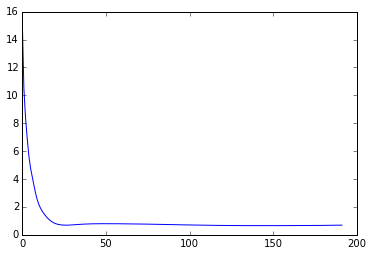

In [167]:
plt.plot(err)